# Pyroを使ってみる

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import jax

/Users/seijmura/miniforge3/envs/juku/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "../00_data/penguins_lter.csv"

use = ['Sample Number', 'Species','Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex']
header = ['sample_number', 'species','culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']

species = {'Adelie Penguin (Pygoscelis adeliae)': 'Adelie',
       'Chinstrap penguin (Pygoscelis antarctica)': 'Chinstrap',
       'Gentoo penguin (Pygoscelis papua)': 'Gentoo'}

df_raw = pd.read_csv(path, usecols=use)
df_shrink = df_raw.set_axis(header, axis='columns').dropna()
df = df_shrink.replace(species)
print(df.shape)
df.head()

(334, 7)


sample_number species  culmen_length_mm  culmen_depth_mm  \
0              1  Adelie              39.1             18.7   
1              2  Adelie              39.5             17.4   
2              3  Adelie              40.3             18.0   
4              5  Adelie              36.7             19.3   
5              6  Adelie              39.3             20.6   

   flipper_length_mm  body_mass_g     sex  
0              181.0       3750.0    MALE  
1              186.0       3800.0  FEMALE  
2              195.0       3250.0  FEMALE  
4              193.0       3450.0  FEMALE  
5              190.0       3650.0    MALE

In [3]:
species_int = {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}

x_std = zscore(df.body_mass_g.values)
y_std = zscore(df.culmen_length_mm.values)
g = df.species.replace(species_int).values.astype(int)


In [4]:
def model(g, y, x):
    mu_intercept = numpyro.sample("mu_intercept", dist.Normal(0.0,100.0))
    sigma_intercept = numpyro.sample("sigma_intercept", dist.HalfCauchy(0.25))
    mu_slope = numpyro.sample("mu_slope", dist.Normal(0.0,100.0))
    sigma_slope = numpyro.sample("sigma_slope", dist.HalfCauchy(0.25))
    
    n_group = len(np.unique(np.array(g)))
    
    with numpyro.plate("plate_i", n_group):
        intercept = numpyro.sample("intercept", dist.Normal(mu_intercept, sigma_intercept))
        slope = numpyro.sample("slope", dist.Normal(mu_slope, sigma_slope))
    
    sigma = numpyro.sample("sigma", dist.HalfCauchy(1.0))
    link_function = intercept[g] + slope[g] * x
    
    with numpyro.plate("data", len(g)):
        numpyro.sample("obs", dist.Normal(link_function, sigma), obs=y)
#-
    

In [5]:
%%time

numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

samples = 10000
burnin = 4000
num_chain = 4

nuts_kernel = NUTS(model)


CPU times: user 96 µs, sys: 2 µs, total: 98 µs
Wall time: 98.9 µs


In [ ]:
%%time 

mcmc = MCMC(nuts_kernel, num_samples=samples, num_warmup=burnin, num_chains=num_chain)



: 

: 

In [ ]:

rng_key = jax.random.PRNGKey(0)


In [ ]:

mcmc.run(rng_key, g, y_std, x_std)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 14000/14000 [00:07<00:00, 1999.74it/s, 31 steps of size 1.75e-01. acc. prob=0.87]


In [ ]:
numpyro.set_host_device_count(4)
jax.local_device_count("cpu")

4

In [ ]:
jax.devices("cpu")

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [ ]:
mcmc.print_summary()
#prob で確信区間の設定が可能


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
     intercept[0]     -0.63      0.05     -0.63     -0.72     -0.54    385.69      1.01
     intercept[1]      1.24      0.07      1.23      1.11      1.36   4806.98      1.00
     intercept[2]      0.01      0.08      0.01     -0.12      0.13    884.40      1.01
     mu_intercept      0.22      0.70      0.24     -0.84      1.25   3622.51      1.00
         mu_slope      0.57      0.12      0.56      0.41      0.73   6652.32      1.00
            sigma      0.44      0.02      0.44      0.42      0.47  11912.69      1.00
  sigma_intercept      1.10      0.74      0.92      0.39      1.79   7185.67      1.00
      sigma_slope      0.13      0.15      0.09      0.01      0.27    608.70      1.01
         slope[0]      0.51      0.06      0.51      0.41      0.62    369.96      1.01
         slope[1]      0.60      0.09      0.59      0.46      0.75   1040.27      1.01
         slope[2]      0.59    

array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'mu_intercept'}>,
        <AxesSubplot:title={'center':'mu_intercept'}>],
       [<AxesSubplot:title={'center':'mu_slope'}>,
        <AxesSubplot:title={'center':'mu_slope'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'sigma_intercept'}>,
        <AxesSubplot:title={'center':'sigma_intercept'}>],
       [<AxesSubplot:title={'center':'sigma_slope'}>,
        <AxesSubplot:title={'center':'sigma_slope'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>]], dtype=object)

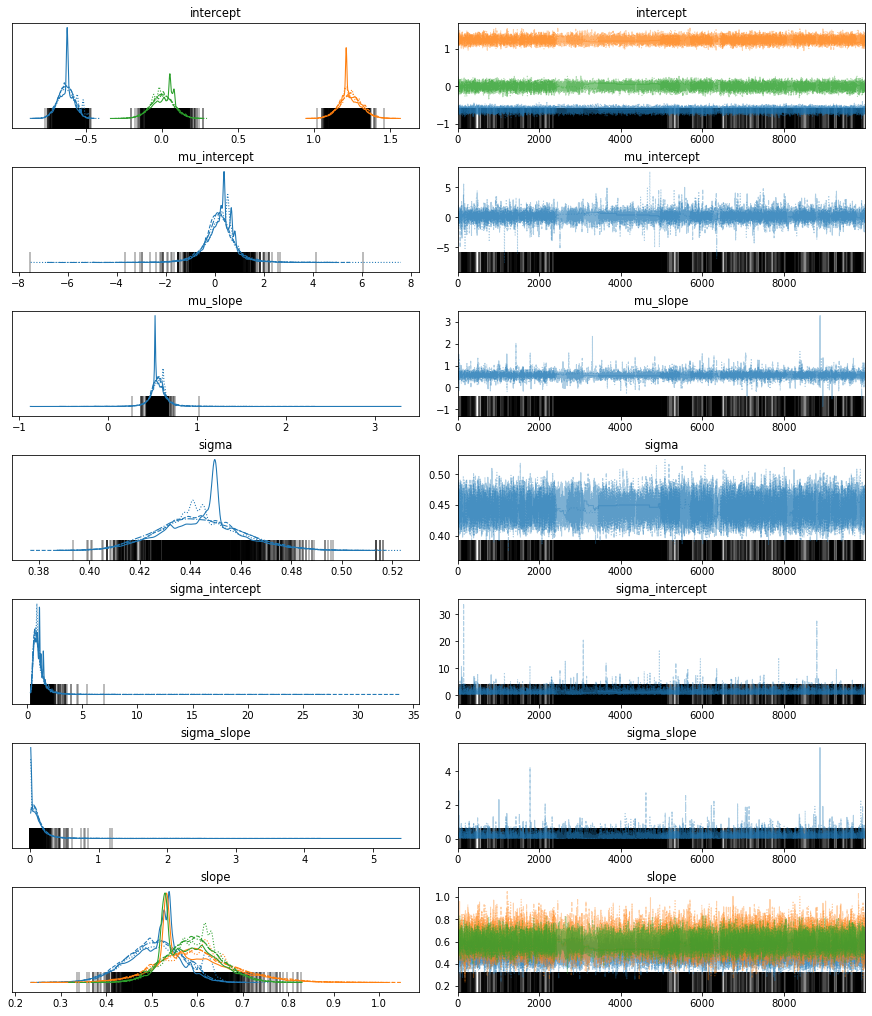

In [ ]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True)